In [1]:
import warnings

import matplotlib as mpl
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)


Loading pyMOR defaults from file /builds/pymor/pymor/docs/source/pymor_defaults.py


# Tutorial: Model order reduction for PDE-constrained optimization problems

A typical application of model order reduction for PDEs are
PDE-constrained parameter optimization problems. These problems aim to
find a local minimizer of an objective functional depending on an
underlying PDE which has to be solved for all evaluations.
A prototypical example of a PDE-constrained optimization problem can be defined
in the following way. For a physical domain {math}`\Omega \subset \mathbb{R}^d` and a
parameter set {math}`\mathcal{P} \subset \mathbb{R}^P`, we want to find
a solution of the minimization problem

```{math}
\min_{\mu \in \mathcal{P}} J(u_{\mu}, \mu),  \tag{P.a}
```

where {math}`u_{\mu} \in V := H^1_0(\Omega)` is the solution of

```{math}
\begin{equation} \label{eq:primal}
a_{\mu}(u_{\mu}, v) = f_{\mu}(v) \qquad \forall \, v \in V \tag{P.b}.
\end{equation}
```

The equation {math}`\eqref{eq:primal}` is called the primal
equation and can be arbitrarily complex. MOR methods in the context of
PDE-constrained optimization problems thus aim to find a surrogate model
of {math}`\eqref{eq:primal}` to reduce the computational costs of
an evaluation of {math}`J(u_{\mu}, \mu)`.

If there exists a unique solution {math}`u_{\mu}` for all
{math}`\mu \in \mathcal{P}`, we can rewrite ({math}`\textrm{P}`) by using the so-called
reduced objective functional {math}`\mathcal{J}(\mu):= J(u_{\mu}, \mu)`
leading to the equivalent problem: Find a solution of

```{math}
\min_{\mu \in \mathcal{P}} \mathcal{J}(\mu).  \tag{$\hat{P}$}
```

There exist plenty of different methods to solve ({math}`\hat{P}`) by
using MOR methods. Some of them rely on an RB method with traditional
offline/online splitting, which typically result in a very online
efficient approach. Recent research also tackles overall efficiency by
overcoming the expensive offline phase, which we will discuss further
below.

In this tutorial, we use a simple linear scalar valued objective functional
and an elliptic primal equation to compare different approaches that solve
({math}`\hat{P}`).

## An elliptic model problem with a linear objective functional

We consider a domain {math}`\Omega:= [-1, 1]^2`, a parameter set
{math}`\mathcal{P} := [0,\pi]^2` and the elliptic equation

```{math}
- \nabla \cdot \big( \lambda(\mu) \nabla u_\mu \big) = l
```

with data functions

```{math}
\begin{align}
l(x, y) &= \tfrac{1}{2} \pi^2 \cos(\tfrac{1}{2} \pi x) \cos(\tfrac{1}{2} \pi y),\\
\lambda(\mu) &= \theta_0(\mu) \lambda_0 + \theta_1(\mu) \lambda_1,\\
\theta_0(\mu) &= 1.1 + \sin(\mu_0)\mu_1,\\
\theta_1(\mu) &= 1.1 + \sin(\mu_1),\\
\lambda_0 &= \chi_{\Omega \backslash \omega},\\
\lambda_1 &= \chi_\omega,\\
\omega &:= [-\tfrac{2}{3}, -\tfrac{1}{3}]^2 \cup ([-\tfrac{2}{3}, -\tfrac{1}{3}] \times [\tfrac{1}{3}, \tfrac{2}{3}]).
\end{align}
```

The diffusion is thus given as the linear combination of scaled
indicator functions where {math}`\omega` is defined by two blocks in the
left half of the domain, roughly where the `w` is here:

```
+-----------+
|           |
|  w        |
|           |
|  w        |
|           |
+-----------+
```

From the definition above we can easily deduce the bilinear form
{math}`a_{\mu}` and the linear functional {math}`f_{\mu}` for the primal
equation. Moreover, we consider the linear objective functional

```{math}

\mathcal{J}(\mu) := \theta_{\mathcal{J}}(\mu)\, f_\mu(u_\mu)

```

where {math}`\theta_{\mathcal{J}}(\mu) := 1 + \frac{1}{5}(\mu_0 + \mu_1)`.

With this data, we can construct a `StationaryProblem` in pyMOR.

In [2]:
from pymor.basic import *
import numpy as np

domain = RectDomain(([-1,-1], [1,1]))
indicator_domain = ExpressionFunction(
    '(-2/3. <= x[0]) * (x[0] <= -1/3.) * (-2/3. <= x[1]) * (x[1] <= -1/3.) * 1. \
   + (-2/3. <= x[0]) * (x[0] <= -1/3.) *  (1/3. <= x[1]) * (x[1] <=  2/3.) * 1.',
    dim_domain=2)
rest_of_domain = ConstantFunction(1, 2) - indicator_domain

l = ExpressionFunction('0.5*pi*pi*cos(0.5*pi*x[0])*cos(0.5*pi*x[1])', dim_domain=2)

parameters = {'diffusion': 2}
thetas = [ExpressionParameterFunctional('1.1 + sin(diffusion[0])*diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['cos(diffusion[0])*diffusion[1]',
                                                                             'sin(diffusion[0])']}),
          ExpressionParameterFunctional('1.1 + sin(diffusion[1])', parameters,
                                       derivative_expressions={'diffusion': ['0',
                                                                             'cos(diffusion[1])']}),

                                       ]
diffusion = LincombFunction([rest_of_domain, indicator_domain], thetas)

theta_J = ExpressionParameterFunctional('1 + 1/5 * diffusion[0] + 1/5 * diffusion[1]', parameters,
                                        derivative_expressions={'diffusion': ['1/5','1/5']})

problem = StationaryProblem(domain, l, diffusion, outputs=[('l2', l * theta_J)])

We now use pyMOR's builtin discretization toolkit (see {doc}`tutorial_builtin_discretizer`)
to construct a full order `StationaryModel`. Since we intend to use a fixed
energy norm

```{math}
\|\,.\|_{\bar{\mu}} : = a_{\,\bar{\mu}}(.,.),
```

we also define {math}`\bar{\mu}`, which we pass via the argument
`mu_energy_product`. Also, we define the parameter space
{math}`\mathcal{P}` on which we want to optimize.

In [3]:
mu_bar = problem.parameters.parse([np.pi/2,np.pi/2])

fom, data = discretize_stationary_cg(problem, diameter=1/50, mu_energy_product=mu_bar)
parameter_space = fom.parameters.space(0, np.pi)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

We now define the first function for the output of the model that will be used by the minimizer.

In [4]:
def fom_objective_functional(mu):
    return fom.output(mu)[0, 0]

We also pick a starting parameter for the optimization method,
which in our case is {math}`\mu^0 = (0.25, 0.5)`.

In [5]:
initial_guess = [0.25, 0.5]

Next, we visualize the diffusion function {math}`\lambda_\mu` by using
`InterpolationOperator` for interpolating it on the grid.

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(fom.parameters.parse(initial_guess))
fom.visualize(diff)

In [7]:
print(data['grid'])

Tria-Grid on domain [-1,1] x [-1,1]
x0-intervals: 100, x1-intervals: 100
elements: 40000, edges: 60200, vertices: 20201


We can see that our FOM model has 20201 DoFs which just about suffices
to resolve the data structure in the diffusion. This suggests to use an
even finer mesh. However, for enabling a faster runtime for this
tutorial, we stick with this mesh and remark that refining the mesh does
not change the interpretation of the methods that are discussed below.
It rather further improves the speedups achieved by model reduction.

Before we discuss the first optimization method, we define helpful
functions for visualizations.

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1
mpl.rcParams['axes.facecolor'] = (0.0, 0.0, 0.0, 0.0)

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt
from time import perf_counter

def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x

def plot_3d_surface(f, x, y, alpha=1):
    X, Y = x, y
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, f_of_x = compute_value_matrix(f, x, y)
    ax.plot_surface(x, y, f_of_x, cmap='Blues',
                    linewidth=0, antialiased=False, alpha=alpha)
    ax.view_init(elev=27.7597402597, azim=-39.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    return ax

def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

Now, we can visualize the objective functional on the parameter space

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

<Axes3D: >

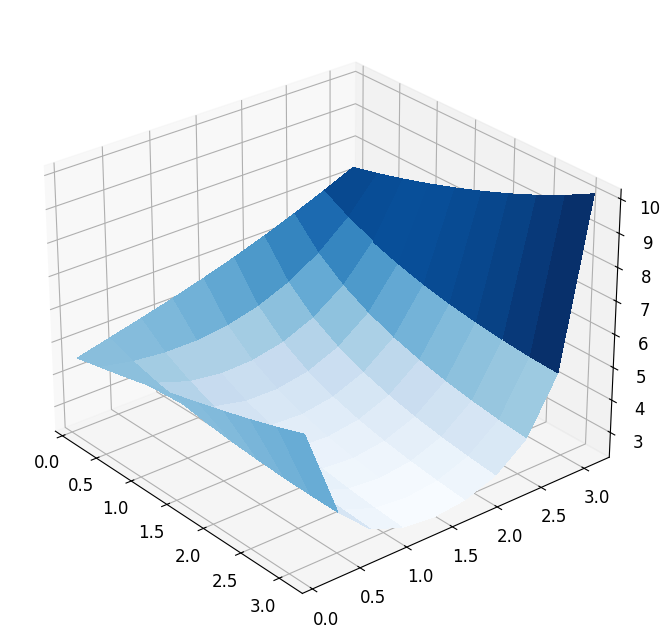

In [9]:
ranges = parameter_space.ranges['diffusion']
XX = np.linspace(ranges[0] + 0.05, ranges[1], 10)

plot_3d_surface(fom_objective_functional, XX, XX)

Taking a closer look at the functional, we see that it is at least
locally convex with a locally unique minimum. In general, however,
PDE-constrained optimization problems are not convex. In our case
changing the parameter functional {math}`\theta_{\mathcal{J}}` can
already result in a very different non-convex output functional.

In order to record some data during the optimization, we also define
helpful functions for recording and reporting the results in this tutorial.

In [10]:
def prepare_data(offline_time=False, enrichments=False):
    data = {'num_evals': 0, 'evaluations' : [], 'evaluation_points': [], 'time': np.inf}
    if offline_time:
        data['offline_time'] = offline_time
    if enrichments:
        data['enrichments'] = 0
    return data

def record_results(function, data, adaptive_enrichment=False, opt_dict=None, mu=None):
    if adaptive_enrichment:
        # this is for the adaptive case! rom is shipped via the opt_dict argument.
        assert opt_dict is not None
        QoI, data, rom = function(mu, data, opt_dict)
        opt_dict['opt_rom'] = rom
    else:
        QoI = function(mu)
    data['num_evals'] += 1
    data['evaluation_points'].append(mu)
    data['evaluations'].append(QoI)
    return QoI

def report(result, data, reference_mu=None):
    if (result.status != 0):
        print('\n failed!')
    else:
        print('\n succeeded!')
        print(f'  mu_min:    {fom.parameters.parse(result.x)}')
        print(f'  J(mu_min): {result.fun}')
        if reference_mu is not None:
            print(f'  absolute error w.r.t. reference solution: {np.linalg.norm(result.x-reference_mu):.2e}')
        print(f'  num iterations:     {result.nit}')
        print(f'  num function calls: {data["num_evals"]}')
        print(f'  time:               {data["time"]:.5f} seconds')
        if 'offline_time' in data:
                print(f'  offline time:       {data["offline_time"]:.5f} seconds')
        if 'enrichments' in data:
                print(f'  model enrichments:  {data["enrichments"]}')
    print('')

## Optimizing with the FOM using finite differences

There exist plenty optimization methods, and this tutorial is not meant
to discuss the design and implementation of optimization methods. We
simply use the `minimize` function
from `scipy.optimize` and use the
builtin `L-BFGS-B` routine which is a quasi-Newton method that can
also handle a constrained parameter space. For the whole tutorial, we define the
optimization function as follows.

In [11]:
from functools import partial
from scipy.optimize import minimize

def optimize(J, data, ranges, gradient=False, adaptive_enrichment=False, opt_dict=None):
    tic = perf_counter()
    result = minimize(partial(record_results, J, data, adaptive_enrichment, opt_dict),
                      initial_guess,
                      method='L-BFGS-B', jac=gradient,
                      bounds=(ranges, ranges),
                      options={'ftol': 1e-15, 'gtol': 5e-5})
    data['time'] = perf_counter()-tic
    return result

It is optional to give an expression for the gradient of the objective
functional to the `minimize` function.
In case no gradient is given, `minimize`
just approximates the gradient with finite differences.
This is not recommended because the gradient is inexact and the
computation of finite differences requires even more evaluations of the
primal equation. Here, we use this approach for a simple demonstration.

In [12]:
reference_minimization_data = prepare_data()

fom_result = optimize(fom_objective_functional, reference_minimization_data, ranges)

reference_mu = fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [13]:
report(fom_result, reference_minimization_data)


 succeeded!
  mu_min:    {diffusion: [1.424650393660458, 3.141592653589793]}
  J(mu_min): 2.391707876327525
  num iterations:     7
  num function calls: 27
  time:               1.94800 seconds



Taking a look at the result, we see that the optimizer needs {math}`7`
iterations to converge, but actually needs {math}`27` evaluations of the
full order model. Obviously, this is related to the computation of the
finite differences. We can visualize the optimization path by plotting
the chosen points during the minimization.

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

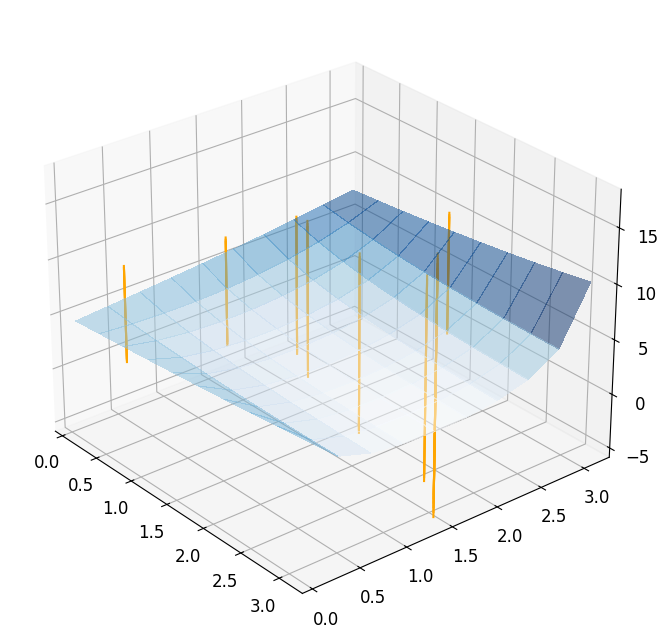

In [14]:
reference_plot = plot_3d_surface(fom_objective_functional, XX, XX, alpha=0.5)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

## Computing the gradient of the objective functional

A major issue of using finite differences for computing the gradient of
the objective functional is the number of evaluations of the objective
functional. In the FOM example from above we saw that
many evaluations of the model were only due to the
computation of the finite differences. If the problem is more complex
and the mesh is finer, this can lead to a serious waste of
computational time. Also from an optimizational point of view it is
always better to compute the true gradient of the objective functional.

For computing the gradient of the linear objective functional
{math}`\mathcal{J}(\mu)`, we can write for every direction
{math}`i= 1, \dots, P`

```{math}
\begin{align} \label{gradient:sens} \tag{1}
d_{\mu_i} \mathcal{J}(\mu) = \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_u J(u_{\mu}, \mu)[d_{\mu_i} u_{\mu}]
   =   \partial_{\mu_i} J(u_{\mu}, \mu) + J(d_{\mu_i} u_{\mu}, \mu)
\end{align}
```

Thus, we need to compute the derivative of the
solution {math}`u_{\mu}` (also called sensitivity). For this, we need to
solve another equation: Find {math}`d_{\mu_i} u_{\mu} \in V`, such that

```{math}
 \label{sens} \tag{2}
a_\mu(d_{\mu_i} u_{\mu}, v) = \partial_{\mu_i} r_\mu^{\text{pr}}(u_{\mu})[v] \qquad \qquad \forall v \in V
```

where {math}`r_\mu^{\text{pr}}` denotes the residual of the primal
equation, i.e.

```{math}
r_\mu^{\text{pr}}(u)[v] := l_\mu(v) - a_\mu(u, v) \qquad \qquad \text{for all }v \in V
```

A major issue of this approach is that the computation of the
full gradient requires {math}`P` solutions of {math}`\eqref{sens}`.
Especially for high dimensional parameter spaces, we can instead use an
adjoint approach to reduce the computational cost to only one solution
of an additional problem.

The adjoint approach relies on the Lagrangian of the objective
functional

```{math}
\mathcal{L}(u, \mu, p) = J(u, \mu) + r_\mu^{\text{pr}}(u, p)
```

where {math}`p \in V` is the adjoint variable. Deriving optimality
conditions for {math}`\mathcal{L}`, we end up with the dual equation:
Find {math}`p_{\mu} \in V`, such that

```{math}
 \label{dual} \tag{3}
a_\mu(v, p_\mu) = \partial_u J(u_\mu, \mu)[v]
= J(v, \mu)
```

Note that in our case, we then have
{math}`\mathcal{L}(u_{\mu}, \mu, p_{\mu}) = J(u, \mu)` because the
residual term {math}`r_\mu^{\text{pr}}(u_{\mu}, p_{\mu})` vanishes since {math}`u_{\mu}`
solves {math}`\eqref{eq:primal}` and {math}`p_{\mu}` is in the test space {math}`V`. By
using the solution of the dual problem, we can then derive the gradient of the objective
functional by

```{math}
\begin{align}
d_{\mu_i} \mathcal{J}(\mu) &= \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_u J(u_{\mu}, \mu)[d_{\mu_i} u_{\mu}] \\
   &=   \partial_{\mu_i} J(u_{\mu}, \mu) + a_\mu(d_{\mu_i} u_{\mu}, p_\mu) \\
   &=   \partial_{\mu_i} J(u_{\mu}, \mu) + \partial_{\mu_i} r_\mu^{\text{pr}}(u_{\mu})[p_\mu]
\end{align}
```

We conclude that we only need to solve for {math}`u_{\mu}` and
{math}`p_{\mu}` if we want to compute the gradient with the adjoint
approach. For more information on this approach we refer to Section 1.6.2 in {cite}`HPUU09`.

We now intend to use the gradient to speed up the optimization methods
from above. All technical requirements are
already available in pyMOR.

## Optimizing using a gradient in FOM

We can easily include a function to compute the gradient to `minimize`
by using the `output_d_mu` method.
However, this method returns a dict w.r.t. the parameters.
In order to use the output for `minimize` we use the output's
`to_numpy` method
to convert the values to a single NumPy array.

In [15]:
def fom_gradient_of_functional(mu):
    return fom.output_d_mu(fom.parameters.parse(mu)).to_numpy()

opt_fom_minimization_data = prepare_data()

opt_fom_result = optimize(fom_objective_functional, opt_fom_minimization_data, ranges,
                          gradient=fom_gradient_of_functional)

# update the reference_mu because this is more accurate!
reference_mu = opt_fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [16]:
report(opt_fom_result, opt_fom_minimization_data)


 succeeded!
  mu_min:    {diffusion: [1.424655696361456, 3.141592653589793]}
  J(mu_min): 2.39170787621399
  num iterations:     7
  num function calls: 9
  time:               1.95300 seconds



With respect to the FOM result with finite differences, we see that we have saved several evaluations
of the function when using the gradient. Of course it is also not for free to compute the gradient,
but since we are using the dual approach, this will only scale with a factor of 2. Furthermore,
we can expect that the result above is more accurate which is why we choose it as the reference parameter.

## Adaptive trust-region optimization using reduced basis methods

As a simple idea to circumvent the costly solutions of the FOM, one could build a reduced order model
offline and use it online as a replacement for the FOM. However, in the context of PDE-constrained
optimization, it is not meaningful to ignore the offline time required to build the RB surrogate since
it can happen that FOM optimization methods would already converge before the surrogate model is even
ready. Building a RB model that is accurate in the whole parameter space is thus usually too expensive.
Thinking about this issue again, it is important to notice that
we are solving an optimization problem which will eventually converge to
a certain parameter. Thus, it only matters that the surrogate is good in
this particular region as long as we are able to arrive at it. This
gives hope that there must exist a more efficient way of using RB
methods without trying to approximate the FOM across the
whole parameter space.

To this end, we can use trust-region methods to adaptively enrich the ROM with respect to
the underlying error estimator. In the trust-region method, we iteratively replace the
global problem with local surrogates, compute local solutions to these surrogate problems,
and enhance the surrogate models when we either are close to the boundary of the trust-region
or when the model confidence decreases such that we require more data.
The local surrogates are required to be accurate only locally, which avoids the construction
of a globally accurate ROM. These local surrogates are built using FOM solutions and gradients.
A speedup is obtained if many of the optimization steps based on FOM evaluations can be replaced
by much cheaper iterations of the ROM and only a few FOM computations are required to build the
reduced models.

The trust-region algorithm consists of one outer loop and many inner loops.
The outer loop iterates over the global parameter space and constructs local trust-regions along
with their corresponding surrogates, whereas the inner loops use a modified version of the
projected BFGS algorithm to solve the local problems. For a fixed parameter in the outer
iteration {math}`\mu` and the current surrogate model {math}`J_r`, the local problems can be
written as

```{math}
\min_{\mu + s \in \Delta} J_r(u_{\mu + s}, \mu + s).  \tag{$\hat{P}_r$}
```

In the formulation of ({math}`\hat{P}_r`), {math}`\Delta \subseteq \mathcal{P}` is the
trust-region with tolerance {math}`\tau > 0` for an error estimator {math}`e_r` of our choice,
in which the updated parameter {math}`\mu + s` satisfies

```{math}
e_r(\mu + s) < \tau.
```

In metric settings such as with the {math}`2`-norm in parameter space, these trust-regions
correspond to open balls of radius {math}`\tau`. However, using model reduction error
estimators as in this tutorial, creates much more complex shapes.
The sketch below shows an exemplary optimization path with inner and outer iterations and the
respective trust-regions.

```{image} trust_region_plot.png
:alt: Sketch of the optimization path of a trust-region method
:width: 50%
:align: center
```

The adaptive component of this algorithm is the choice of the trust-radius and the enrichment.
If a local optimization in an inner loop fails, we retry the surrogate problem with a
smaller trust-region, thus limiting the trustworthiness of the current model.
In contrast, when we quickly converge close to the boundary of the trust-region, it is a
reasonable assumption that the globally optimal parameter is outside of the trust-region
and, thus, we stop the inner iteration. After computing an inner solution we then have the
option to keep the current surrogate model, enlarge the trust-radius of the local model
or further enrich it by adding the FOM solution snapshot at the current local optimum.
In this sense, the adaptive trust-region algorithm can reduce the number of FOM evaluations
by estimating whether the current surrogate is trustworthy enough to increase the trust-radius
and only enriching the model if the estimated quality is no longer sufficient.

The algorithm described above can be executed as follows.

In [17]:
from pymor.algorithms.tr import coercive_rb_trust_region
from pymor.parameters.functionals import MinThetaParameterFunctional

coercivity_estimator = MinThetaParameterFunctional(fom.operator.coefficients, mu_bar)
pdeopt_reductor = CoerciveRBReductor(
    fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)

tic = perf_counter()
tr_mu, tr_minimization_data = coercive_rb_trust_region(pdeopt_reductor, parameter_space=parameter_space,
                                                       initial_guess=np.array(initial_guess))
toc = perf_counter()

tr_minimization_data['time'] = toc - tic
tr_output = fom.output(tr_mu)[0, 0]

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Now, we only need {math}`4` enrichments and end up with an approximation
error of about `1e-06` which is comparable to the result obtained from the
previous methods.
To conclude, we once again compare all methods that we have discussed in this notebook.

In [18]:
from pymordemos.trust_region import report as tr_report
reference_fun = fom_objective_functional(reference_mu)

print('FOM with finite differences')
report(fom_result, reference_minimization_data, reference_mu)

print('\nFOM with gradient')
report(opt_fom_result, opt_fom_minimization_data, reference_mu)

tr_report(tr_mu, tr_output, reference_mu, reference_fun, tr_minimization_data,
    parameter_space.parameters.parse, descriptor=' of optimization with adaptive ROM model and TR method')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

FOM with finite differences

 succeeded!
  mu_min:    {diffusion: [1.424650393660458, 3.141592653589793]}
  J(mu_min): 2.391707876327525
  absolute error w.r.t. reference solution: 5.30e-06
  num iterations:     7
  num function calls: 27
  time:               1.94800 seconds


FOM with gradient

 succeeded!
  mu_min:    {diffusion: [1.424655696361456, 3.141592653589793]}
  J(mu_min): 2.39170787621399
  absolute error w.r.t. reference solution: 0.00e+00
  num iterations:     7
  num function calls: 9
  time:               1.95300 seconds


Report of optimization with adaptive ROM model and TR method:
  mu_min:        {diffusion: [1.4246656693463333, 3.141592653589793]}
  J(mu_min):     2.3917078761287254
  abs parameter error w.r.t. reference solution: 9.97e-06
  abs output error w.r.t. reference solution:    8.53e-11
  num iterations:            3
  num fom evaluations:       7
  num rom evaluations:       224
  num enrichments:           4
  total BFGS iterations:     18
  num line s

It is apparent that for this example no drastic changes occur when using the different
methods. Importantly, the TR method is noticeably faster than the FOM-based methods.
It has been shown in the references mentioned below in the conclusion that for problems
of larger scale the speedup obtained by gradient-based methods and in particular the TR method
is even more pronounced.
Crucially, the number of necessary FOM evaluations in the trust-region method is smaller
than for the other methods because we use the information in the local surrogates more efficiently.

In [19]:
subproblem_data = tr_minimization_data['subproblem_data']

assert tr_minimization_data['fom_evaluations'] == 7
assert tr_minimization_data['rom_evaluations'] == 224
assert tr_minimization_data['enrichments'] == 4
assert sum([subproblem_data[i]['iterations'] for i in range(len(subproblem_data))]) == 18
assert sum(np.concatenate([subproblem_data[i]['line_search_iterations'] for i in range(len(subproblem_data))])) == 114

Note: A more extensive showcase of the trust-region methods is implemented
in the respective demo `trust_region`.

## Conclusion and some general words about MOR methods for optimization

In this tutorial we have seen how pyMOR can be used to speedup the optimizer
for PDE-constrained optimization problems.
The trust-region algorithm shown here is able to efficiently use local surrogate
models to reduce the number of FOM evaluations required during optimization.

We have only covered a few approaches to combine model
reduction with optimization.
For faster and more robust optimization algorithms we refer to the textbooks
[CGT00](<https://epubs.siam.org/doi/book/10.1137/1.9780898719857>) and
[NW06](<https://link.springer.com/book/10.1007/978-0-387-40065-5>).
For recent research on combining trust-region methods with model reduction for
PDE-constrained optimization problems we refer to
[YM13](<https://epubs.siam.org/doi/abs/10.1137/120869171>),
[QGVW17](<https://epubs.siam.org/doi/abs/10.1137/16M1081981>) and
[KMSOV20](<https://www.esaim-m2an.org/articles/m2an/abs/2021/04/m2an200123/m2an200123.html>),
where for the latter a pyMOR implementation is available as supplementary material.

Download the code:
{download}`tutorial_optimization.md`
{nb-download}`tutorial_optimization.ipynb`